# Neural Networks and CNNs with PyTorch Lightning

This notebook is inspired by the [PyTorch Crash Course](https://www.youtube.com/watch?v=OIenNRt2bjg&t=2s) and its accompanying [Google Colab Notebook](https://colab.research.google.com/drive/1eiUBpmQ4m7Lbxqi2xth1jBaL61XTKdxp?usp=sharing).

In this notebook, we build upon the code from the PyTorch Crash Course but adapt it to use **PyTorch Lightning**. 
By using PyTorch Lightning, we aim to make the code cleaner and easier to maintain while achieving the same results as the original implementation.


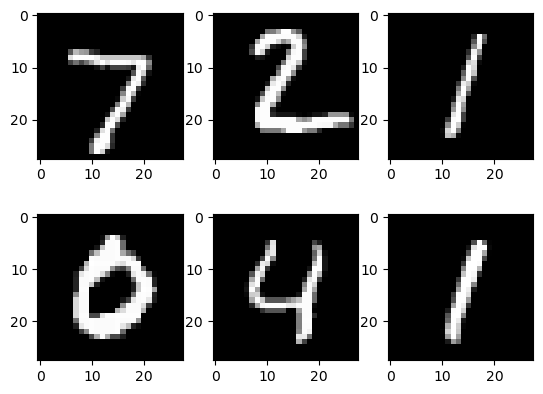

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as L
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 784  # 28x28
hidden_size = 500
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

examples = iter(test_loader)
example_data, example_targets = next(examples)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [2]:
class LightningNeuralNet(L.LightningModule):
  def __init__(self, input_size, hidden_size, num_classes):
    super(LightningNeuralNet, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    return out

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=learning_rate)
  
  def training_step(self, batch, batch_idx):
    images, labels = batch
    images = images.reshape(-1, 28*28)
    outputs = self(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    return loss

model = LightningNeuralNet(input_size, hidden_size, num_classes)
trainer = L.Trainer(max_epochs=num_epochs)
trainer.fit(model, train_loader)

#Test the model and output the accuracy 
with torch.no_grad():
  n_correct = 0
  n_samples = len(test_loader.dataset)
  for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network on the 10000 test images: {acc} %')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/I549593/miniforge3/envs/dljourney/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name | Type   | Params | Mode 
----------------------------------------
0 | l1   | Linear | 392 K  | train
1 | relu | ReLU   | 0      | train
2 | l2   | Linear | 5.0 K  | train
----------------------------------------
397 K     Trainable params
0         Non-trainable params
397 K     Total params
1.590     Total estimated m

Epoch 1: 100%|██████████| 600/600 [00:03<00:00, 160.85it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 600/600 [00:03<00:00, 160.41it/s, v_num=1]
Accuracy of the network on the 10000 test images: 96.9 %


100%|██████████| 170498071/170498071 [00:38<00:00, 4395214.28it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


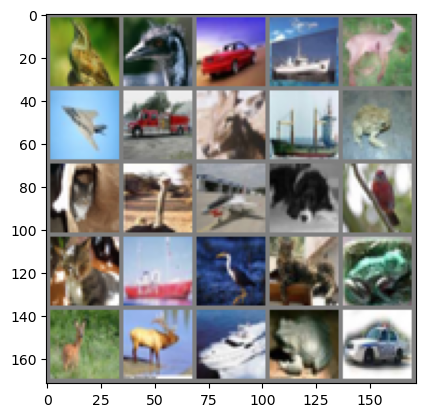

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as L
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(imgs):
    imgs = imgs / 2 + 0.5   # unnormalize
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.show()

# one batch of random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images[0:25], nrow=5)
imshow(img_grid)

In [4]:
class LightningConvNet(L.LightningModule):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv3 = nn.Conv2d(64, 64, 3)
    self.fc1 = nn.Linear(64*4*4, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
      # N, 3, 32, 32
      x = F.relu(self.conv1(x))   # -> N, 32, 30, 30
      x = self.pool(x)            # -> N, 32, 15, 15
      x = F.relu(self.conv2(x))   # -> N, 64, 13, 13
      x = self.pool(x)            # -> N, 64, 6, 6
      x = F.relu(self.conv3(x))   # -> N, 64, 4, 4
      x = torch.flatten(x, 1)     # -> N, 1024
      x = F.relu(self.fc1(x))     # -> N, 64
      x = self.fc2(x)             # -> N, 10
      return x
  
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=learning_rate)
  
  def training_step(self, batch, batch_idx):
    images, labels = batch
    outputs = self(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    return loss

model = LightningConvNet()
trainer = L.Trainer(max_epochs=num_epochs)
trainer.fit(model, train_loader)

#Test the model and output the accuracy 
with torch.no_grad():
  n_correct = 0
  n_samples = len(test_loader.dataset)
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network on the 10000 test images: {acc} %')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv2d    | 896    | train
1 | pool  | MaxPool2d | 0      | train
2 | conv2 | Conv2d    | 18.5 K | train
3 | conv3 | Conv2d    | 36.9 K | train
4 | fc1   | Linear    | 65.6 K | train
5 | fc2   | Linear    | 650    | train
--------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.490     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1563/1563 [00:11<00:00, 132.65it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1563/1563 [00:11<00:00, 132.54it/s, v_num=2]
Accuracy of the network on the 10000 test images: 72.42 %
